<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ-данных" data-toc-modified-id="Предварительный-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вase" data-toc-modified-id="Вase-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вase</a></span></li></ul></li><li><span><a href="#Тренировочная-выборка" data-toc-modified-id="Тренировочная-выборка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Тренировочная выборка</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Validation</a></span></li><li><span><a href="#Answer" data-toc-modified-id="Answer-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Answer</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Уберем-категориальные-данные" data-toc-modified-id="Уберем-категориальные-данные-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Уберем категориальные данные</a></span></li><li><span><a href="#Поменяем-тип-данных" data-toc-modified-id="Поменяем-тип-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Поменяем тип данных</a></span></li><li><span><a href="#Запишем-названия-признаков-в-нижнем-регистре" data-toc-modified-id="Запишем-названия-признаков-в-нижнем-регистре-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Запишем названия признаков в нижнем регистре</a></span></li><li><span><a href="#Перезапишем-id" data-toc-modified-id="Перезапишем-id-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Перезапишем id</a></span></li><li><span><a href="#Масштабируем-признаки" data-toc-modified-id="Масштабируем-признаки-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Масштабируем признаки</a></span></li><li><span><a href="#Подберем-класторы" data-toc-modified-id="Подберем-класторы-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Подберем класторы</a></span></li></ul></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Faiss</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Valid" data-toc-modified-id="Valid-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Valid</a></span></li></ul></li></ul></div>

# Cопоставления (“мэтчинг”) и поиска наиболее похожих товаров.

__Задача:__ 

1) Необходимо разработать алгоритм для маркетплейса, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base. 

2) Oценить качество алгоритма по метрике accuracy@5.

__Описание:__

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss
import seaborn as sns

from sklearn.preprocessing import RobustScaler #StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm

In [2]:
# константы
RANDOM_SEED = 12345
N_CLUSTERS = 10
K_NEIGHBORS = 5
M = 32
NPROBE = 10 

## Подготовка данных

### Предварительный анализ данных

In [3]:
%%time
# загрузим данные и посмотрим на время работы яцейки
try:
    data_base = pd.read_csv(\
                            '/Users/tanya/Documents/DS/Projects/data_matching/data/base.csv', 
                            #index_col='Id'
                           )
except:
    pass        

CPU times: user 1min 4s, sys: 10.3 s, total: 1min 14s
Wall time: 1min 22s


In [4]:
%%time
try:
    data_train = pd.read_csv(\
                             '/Users/tanya/Documents/DS/Projects/data_matching/data/train.csv', 
                             #index_col='Id'
                            )
except:
    pass

CPU times: user 2.44 s, sys: 320 ms, total: 2.76 s
Wall time: 3.04 s


In [5]:
%%time
try:
    data_valid_answer = pd.read_csv(\
                                    '/Users/tanya/Documents/DS/Projects/data_matching/data/validation_answer.csv', 
                                    #index_col='Id'
                                   )
except:
    pass        

CPU times: user 125 ms, sys: 26.8 ms, total: 152 ms
Wall time: 237 ms


In [6]:
%%time
try:
    data_valid = pd.read_csv(\
                             '/Users/tanya/Documents/DS/Projects/data_matching/data/validation.csv', 
                             #index_col='Id'
                             )
except:
    pass

CPU times: user 2.29 s, sys: 268 ms, total: 2.55 s
Wall time: 2.77 s


In [7]:
# функция для изучения данных
def info(data):
    display(data.info())
    display(data.sample(10))
    display(data.describe().T)
    print(data.isna().sum())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество признаков: ', data.shape[1], 'Количество значений: ', data.shape[0])

#### Вase

In [8]:
info(data_base)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
2876329,4649801-base,-39.122270,2.746919,-114.527885,-126.658330,164.171450,-85.144340,-530.124724,-85.411080,134.38376,...,-107.508620,46.128860,-177.25684,-27.648840,66.202030,60.090286,-32.781174,128.233060,49.888578,-31.096294
2640978,4130538-base,-46.464516,10.237693,-78.297030,-147.773910,104.817820,-83.078510,-521.359023,5.966911,122.91164,...,-59.351690,22.842610,-188.17499,-20.762464,69.718690,63.848248,40.545784,127.950270,-1074.464888,-66.107025
1983663,2815034-base,-109.548035,17.460080,-54.359226,-148.091950,73.816230,-68.821550,-759.626065,-76.385690,110.44625,...,-126.242180,15.560360,-208.21426,-21.325246,68.871260,-13.519402,25.411290,88.305435,-943.134292,-90.716920
271472,287574-base,-87.268980,8.014152,-83.202910,-135.860370,61.854595,-79.973040,28.245132,21.932323,132.12730,...,-84.831210,10.125206,-128.92474,54.715241,67.904335,59.576534,8.564877,115.116844,-406.327607,-9.342365
1345275,1726744-base,-69.629105,8.815957,-52.526432,-121.417244,110.114204,-38.679005,-530.124724,-2.952787,124.63721,...,-85.587090,21.562134,-169.43184,126.245604,68.618290,40.721985,-14.328308,94.234460,-1208.436704,-117.387010
1064756,1304235-base,-104.241620,5.666201,-116.685760,-152.911010,71.875690,-47.634773,-224.289358,-19.231200,128.32722,...,-54.324250,7.251951,-227.02191,-89.446393,69.647670,-40.187843,107.705030,113.829765,-1074.464888,46.139690
1409369,1827883-base,-126.191300,9.084493,-48.718440,-135.898200,207.643630,-72.996390,-759.626065,105.529060,119.90970,...,-54.506615,14.769937,-164.29936,100.457202,65.150276,65.756400,137.903440,106.343860,-991.478910,-72.103830
1864383,2597672-base,-98.468796,15.061369,-56.335670,-165.930040,43.906166,-55.909763,-20.419210,80.811290,128.02579,...,-77.660620,-38.659462,-185.56454,151.086660,68.038810,22.485779,87.664380,142.739090,-1014.186689,-61.520847
2661730,4175084-base,-87.387000,4.156797,-91.554900,-155.365430,153.601910,-120.325870,-759.626065,2.733076,138.86755,...,-109.646090,66.642006,-132.27234,151.449141,67.770100,7.461817,79.653244,126.481290,-826.342189,-77.700700
1441891,1879760-base,-117.575714,2.185167,-17.544098,-172.098940,110.357680,-73.082370,-417.456424,76.595474,127.88730,...,-95.880035,13.734779,-110.01341,172.614578,64.678240,19.972640,33.997215,91.518430,-277.716013,-104.030200


,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
...,...,...,...,...,...,...,...,...
67,2918139.0,23.544896,55.342236,-233.138170,-12.516241,23.416494,59.755113,314.898770
68,2918139.0,74.959301,61.345005,-203.601620,33.775737,74.929970,115.876040,339.573850
69,2918139.0,115.566716,21.175183,15.724480,101.686670,116.024445,129.552375,214.706340
70,2918139.0,-799.339026,385.413088,-1297.931468,-1074.464888,-1074.464888,-505.744456,98.770811


Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64
Количество дубликатов:  0
Количество признаков:  73 Количество значений:  2918139


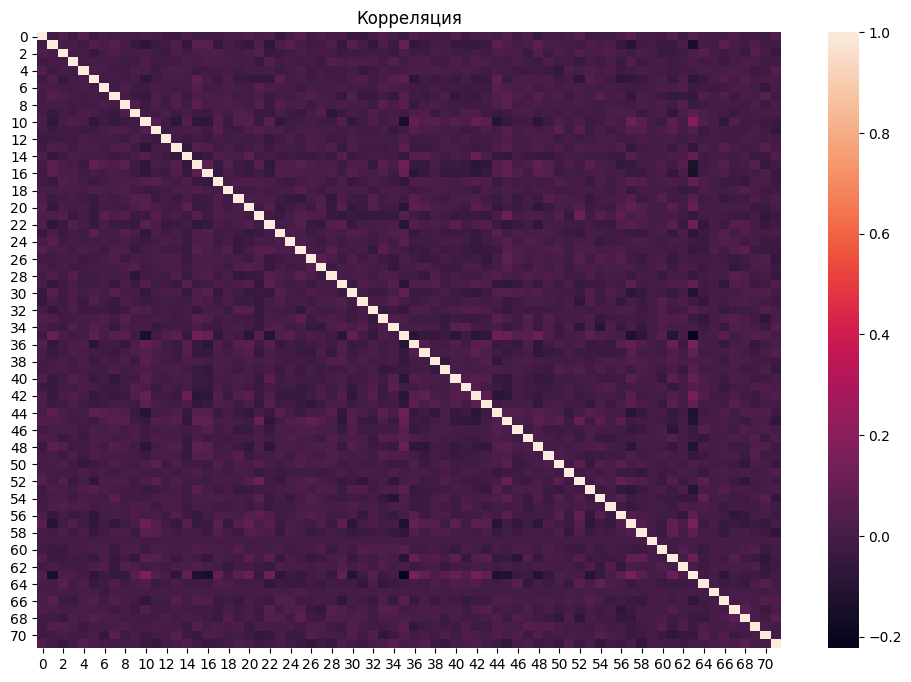

In [9]:
plt.figure(figsize=(12,8))
plt.title('Корреляция')
sns.heatmap(data_base.corr())
plt.show()

__Вывод:__ Имеем данные состоящие из 72 признаков и 2918139 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Необходима стардартизация. Много памяти занимает датафрейм.

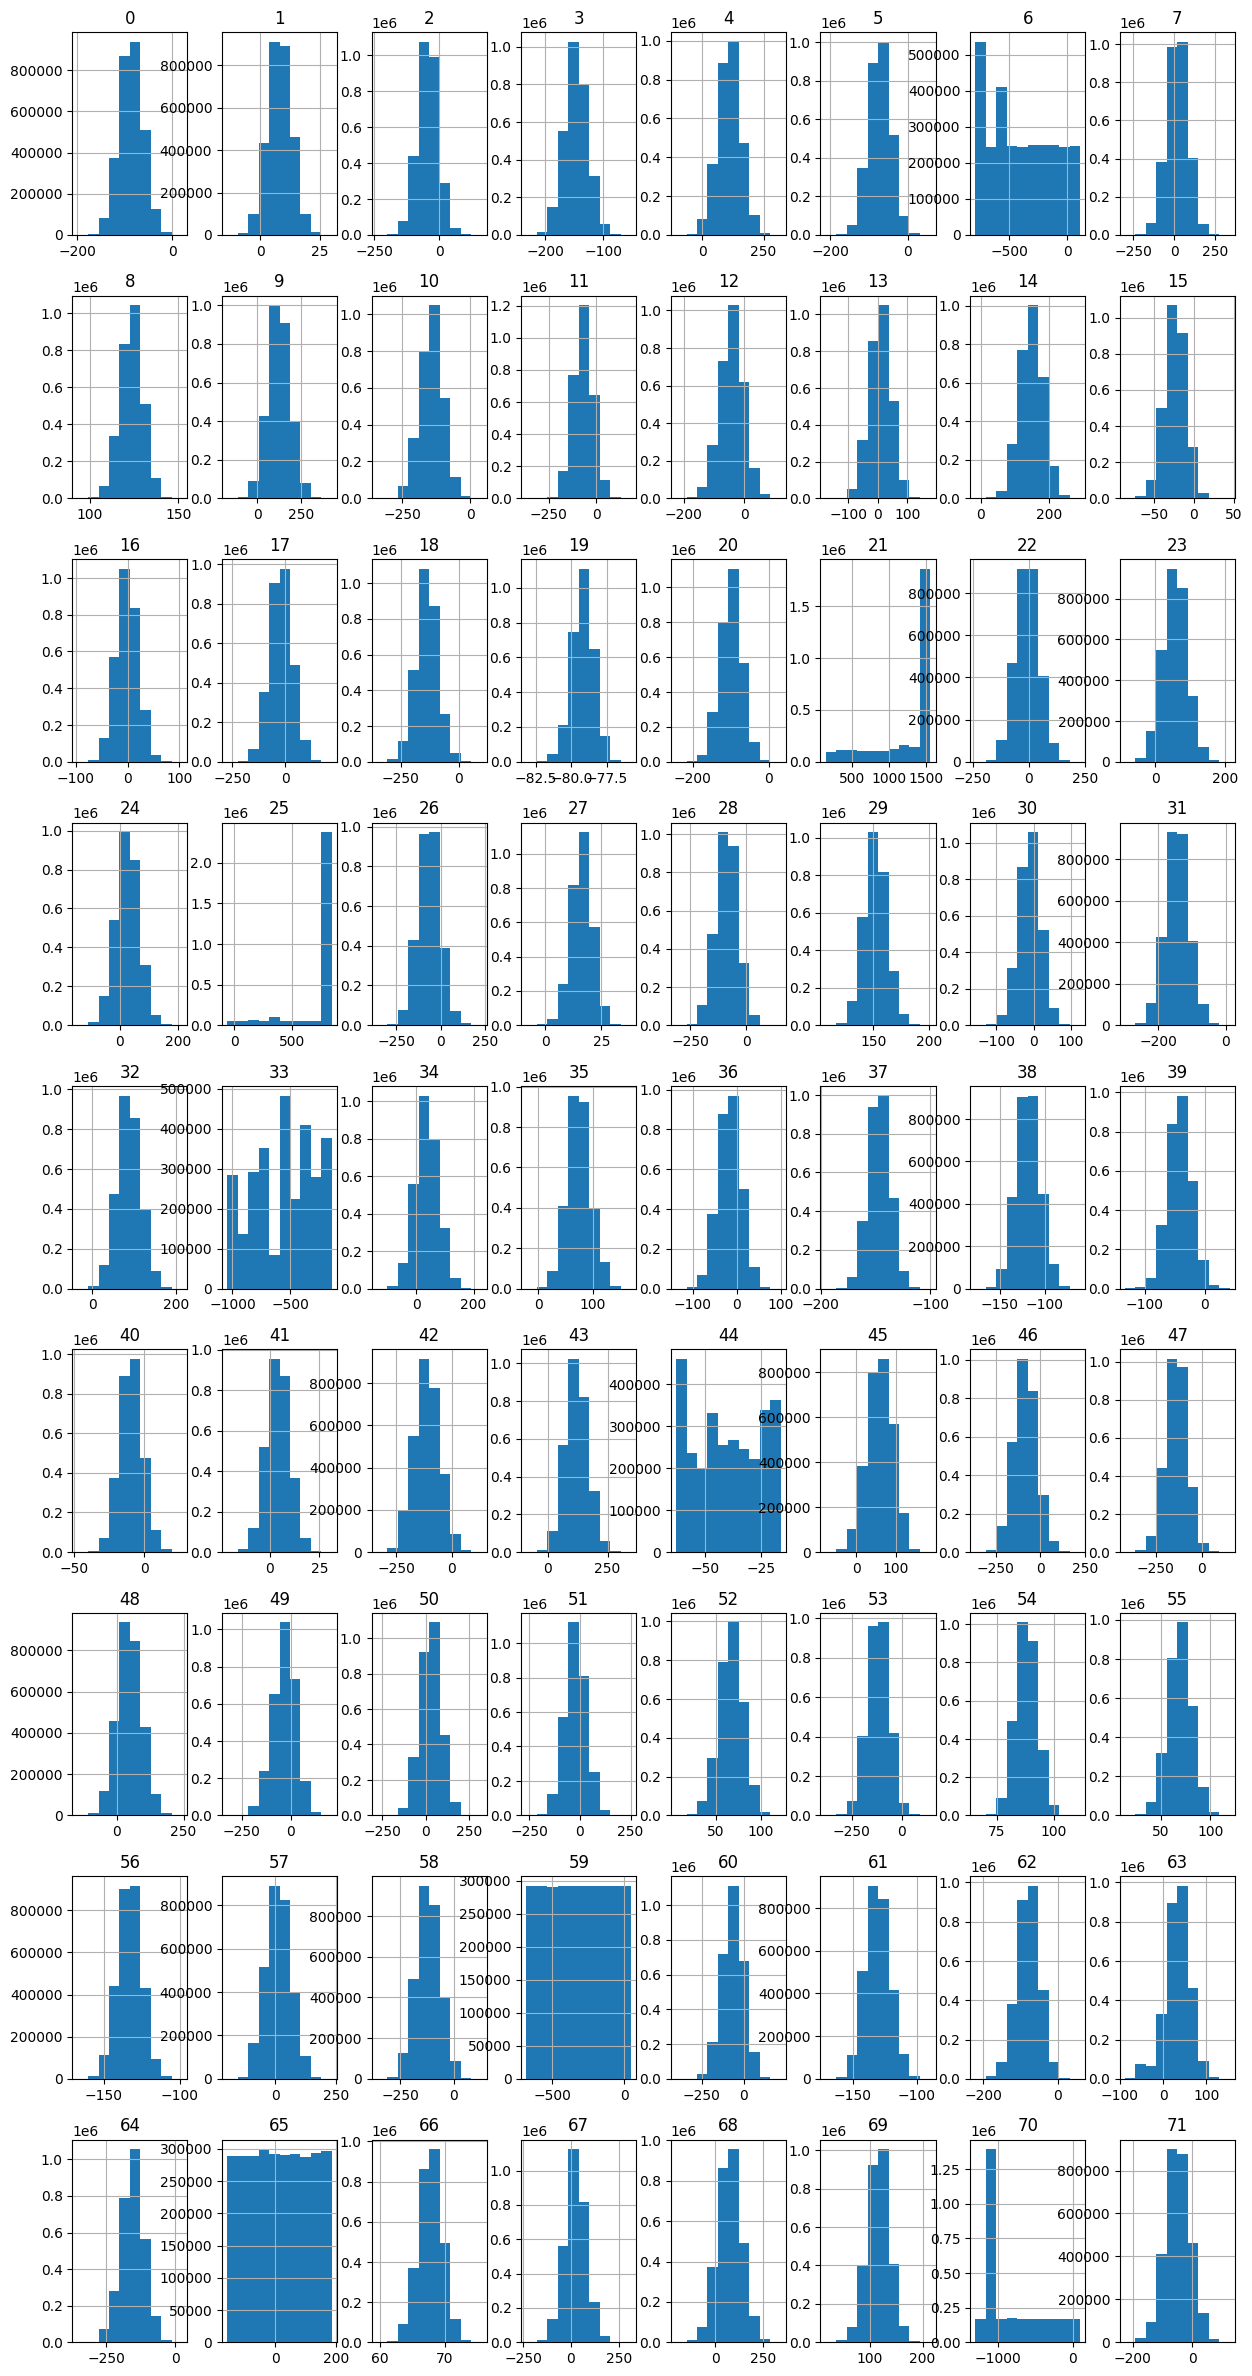

In [10]:
# посмотрим на распределдение
data_base.hist(figsize=(15, 30))
plt.show()

__Вывод:__  Имеем данные состоящие из 71 признаков и 2918139 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Необходима стардартизация. Много памяти занимает датафрейм.

Все признаки кроме 6 21 25 33 44 59 65 70 имеют нормальное распределение.

Изучили признак 33, он имеет 1568 уникальных значений. Это явно категориальный признак. Сложно предположить, что за категория, это явно не цвет и не размер. Возможно это город изготовления товара.

###  Тренировочная выборка

In [11]:
info(data_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
20292,20292-query,-45.501198,2.256059,-81.709730,-150.48943,81.660630,-65.567400,-572.709941,45.883050,129.160770,...,45.714320,-135.916840,-3.959483,65.913666,-130.601790,137.582930,109.282050,-27.659021,-69.412510,178424-base
88962,88962-query,-30.443466,13.838392,-30.188953,-136.56902,89.070650,-68.503910,-206.258673,24.577385,123.555120,...,13.839441,-135.320680,-37.459852,66.667150,47.354137,58.945590,85.541790,-216.701836,-95.548096,57135-base
24957,24957-query,-73.895420,7.843518,-41.375076,-153.47280,115.346640,-79.974490,-524.035659,71.679060,126.447500,...,91.257355,-155.738280,38.739177,67.977550,-3.863728,49.622130,114.137910,-1074.464888,-86.469740,610590-base
77961,77961-query,-29.998730,2.752648,-17.925810,-146.33664,151.667570,-45.356810,-534.608985,-18.773397,115.219240,...,8.590269,-100.594700,-6.441211,71.274475,48.303627,-11.928322,102.953840,-28.546441,-107.749680,249925-base
26,26-query,-93.474330,3.777835,-101.815610,-123.68739,49.253826,-98.615326,-781.865817,70.730545,129.879700,...,17.590708,-102.659300,73.689712,69.401520,15.050840,117.847760,88.287720,-1074.464888,41.221867,3183220-base
65095,65095-query,-103.644630,2.158029,-135.294080,-175.19736,104.107994,-79.714935,-608.418886,-12.419500,117.940630,...,79.717130,-112.134926,13.246146,68.954080,8.567492,154.261350,101.721176,-1168.579826,-37.786682,649116-base
94624,94624-query,-48.179794,15.149202,-56.420982,-149.84158,124.106900,-97.076860,-117.081919,-145.295910,126.342410,...,5.494379,-140.060400,82.402970,66.039314,-65.373490,-40.764732,70.552320,-1141.231325,-130.909040,320400-base
4292,4292-query,-102.967140,17.581080,-35.505672,-130.44876,122.356840,-42.874878,-530.124724,24.175910,117.424385,...,78.917070,-97.797010,145.327574,66.477210,59.525570,109.571230,102.366280,-361.337435,37.021427,333542-base
58523,58523-query,-70.910320,4.169525,-25.374006,-140.86238,159.447720,-88.351814,-45.941728,-17.375483,115.886790,...,50.434204,-208.196460,-64.937286,68.490610,23.652813,145.629180,83.194610,31.505494,75.127290,1694317-base
17751,17751-query,-52.388695,8.772985,-106.190830,-135.38242,112.721290,-78.386680,-473.680362,24.541082,115.639720,...,5.456705,-201.527270,64.241543,66.164790,80.715030,9.715050,140.932590,-172.596190,25.217320,771696-base


,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.328679,25.803845,-186.280270,-103.309147,-85.273695,-67.330810,14.585236
1,100000.0,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.0,-43.667046,39.111064,-224.896060,-69.494487,-42.830246,-17.713690,128.108460
3,100000.0,-146.118630,20.434841,-223.307220,-160.028520,-146.067445,-132.277745,-60.751625
4,100000.0,111.770592,47.700958,-93.272020,79.474322,112.260100,143.760830,301.363600
...,...,...,...,...,...,...,...,...
67,100000.0,23.029277,55.470761,-203.746380,-14.144571,23.441363,59.941065,266.493320
68,100000.0,73.412076,62.203132,-181.973820,31.685548,72.880192,114.469224,319.867520
69,100000.0,115.189717,21.582238,22.598862,100.589324,115.236635,129.791085,201.761260
70,100000.0,-709.761548,405.961084,-1297.871984,-1074.464888,-808.801696,-357.087323,98.768233


Id        0
0         0
1         0
2         0
3         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 74, dtype: int64
Количество дубликатов:  0
Количество признаков:  74 Количество значений:  100000


In [12]:
data_train['Target'].nunique(dropna=True)

91794

Товары из base соответствуют нескольким значениям

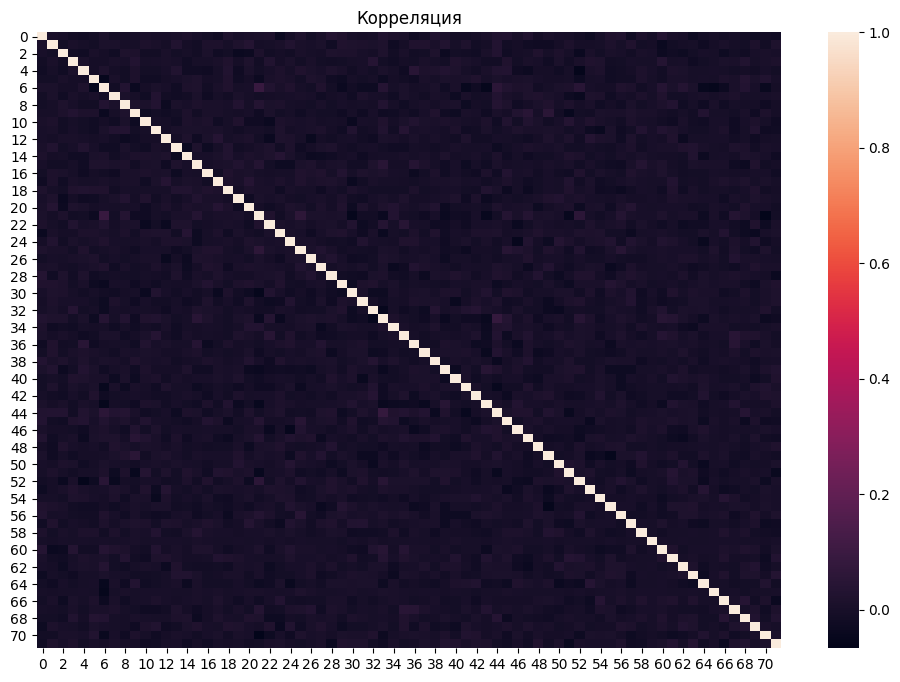

In [13]:
plt.figure(figsize=(12,8))
plt.title('Корреляция')
sns.heatmap(data_train.corr())
plt.show()

In [14]:
pd.set_option('display.max_columns', None)

In [15]:
data_train.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.005141,0.002172,-0.012514,-0.019630,-0.010645,0.009241,-0.010087,-0.009149,0.000220,0.007027,0.004289,0.003673,0.007655,0.015128,0.003132,-0.008481,-0.022408,0.019763,0.001135,0.005462,0.010221,0.012733,-0.035024,-0.006199,0.018574,-0.010525,0.007703,0.035708,0.022266,0.003829,-0.008017,-0.003569,0.028713,0.014442,0.009262,-0.022274,-0.009600,0.029399,0.011045,-0.011484,-0.009616,-0.003441,0.009650,0.028499,0.030206,0.005776,0.026971,-0.005358,0.009493,0.004286,-0.003521,-0.015955,-0.028125,-0.001245,0.023043,0.026547,-0.017992,0.014776,-0.000796,0.034073,0.005025,0.002459,-0.026126,-0.009391,-0.001189,-0.010962,-0.003895,-0.009693,-0.027023,-0.016043,-0.017728
1,0.005141,1.000000,-0.008741,0.005383,-0.000338,-0.008188,0.011282,0.010787,-0.001937,-0.000510,0.015784,0.006932,-0.007723,0.027664,-0.005919,-0.012789,0.015021,0.016351,-0.000749,0.019174,0.035768,-0.007156,-0.002014,0.006214,0.027716,0.006629,0.002290,0.010329,-0.018559,0.023554,0.018034,0.014751,0.012378,0.018388,-0.022882,-0.006991,0.023153,0.021236,0.005467,0.028560,-0.000205,0.018670,-0.013461,-0.006962,0.032269,-0.013384,-0.005031,-0.017825,-0.020858,-0.022481,-0.005888,0.014484,-0.007912,-0.005535,-0.000849,0.016372,-0.003128,0.021643,-0.008404,-0.003961,-0.033542,-0.015680,-0.005167,-0.003761,-0.021873,-0.004735,0.008024,-0.007563,-0.011825,0.016123,-0.014883,0.020817
2,0.002172,-0.008741,1.000000,-0.014821,-0.017966,0.005171,-0.007881,-0.018625,0.020178,0.016323,-0.014603,-0.013534,0.007315,-0.009952,-0.003251,-0.013671,0.011061,-0.018894,-0.010145,-0.033321,-0.029603,0.013811,-0.015377,-0.007977,-0.015913,0.006137,-0.000635,-0.007539,0.020369,0.016661,0.015965,0.002052,-0.004156,0.017707,-0.014751,0.006063,-0.012389,-0.012145,0.017530,-0.029320,-0.010522,-0.013038,-0.017113,0.004956,0.030170,-0.017975,-0.004274,-0.001055,0.023055,-0.001154,0.014251,0.000064,-0.035288,0.007777,-0.011823,0.007628,0.003809,-0.014275,0.007230,0.003399,-0.031276,-0.017713,-0.028888,-0.008702,0.001787,-0.002327,-0.026570,-0.010198,-0.019652,0.002814,0.005712,0.004332
3,-0.012514,0.005383,-0.014821,1.000000,0.009271,-0.007097,-0.004944,0.006825,0.004244,0.033505,-0.001933,0.001797,0.007173,0.002809,-0.017872,-0.000300,-0.001984,0.005175,0.023248,-0.006232,0.017285,-0.016406,0.025767,-0.005493,0.009633,-0.011652,0.004566,-0.008110,-0.012802,-0.011371,-0.002940,0.000956,0.037933,-0.011136,-0.017660,-0.007113,-0.011781,0.007811,-0.000333,-0.010138,0.023141,0.010326,0.000885,-0.015677,-0.013314,0.024509,-0.011782,0.005657,0.001786,-0.018502,0.010543,-0.014693,0.006920,0.024263,0.017521,-0.012679,-0.009765,0.004197,-0.000207,-0.000939,0.033989,-0.002774,0.002490,-0.024133,-0.008766,-0.001255,0.012300,0.004461,0.026721,-0.003116,0.005844,0.014606
4,-0.019630,-0.000338,-0.017966,0.009271,1.000000,-0.006796,0.020441,-0.007682,-0.013266,0.016618,-0.010511,-0.011294,0.002759,0.028691,-0.018261,-0.019195,-0.021364,-0.000542,0.026936,-0.021859,0.009376,-0.010138,0.002653,0.014648,-0.002679,0.021189,0.010525,0.004145,0.018822,0.005353,-0.012273,0.003115,-0.011038,0.009320,-0.002272,-0.021588,0.047617,0.014986,0.017710,0.031266,0.018444,-0.000723,-0.016333,0.007393,0.026820,0.032976,-0.024403,-0.030029,-0.005157,-0.008064,-0.019777,-0.001807,-0.054434,0.004559,0.013157,-0.018095,-0.014800,-0.006734,0.012877,0.001208,-0.012673,0.013195,0.009002,-0.002062,-0.001907,0.002237,-0.003915,-0.011723,-0.005744,-0.012335,0.000445,-0.008475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.003895,-0.007563,-0.010198,0.004461,-0.011723,0.005113,0.

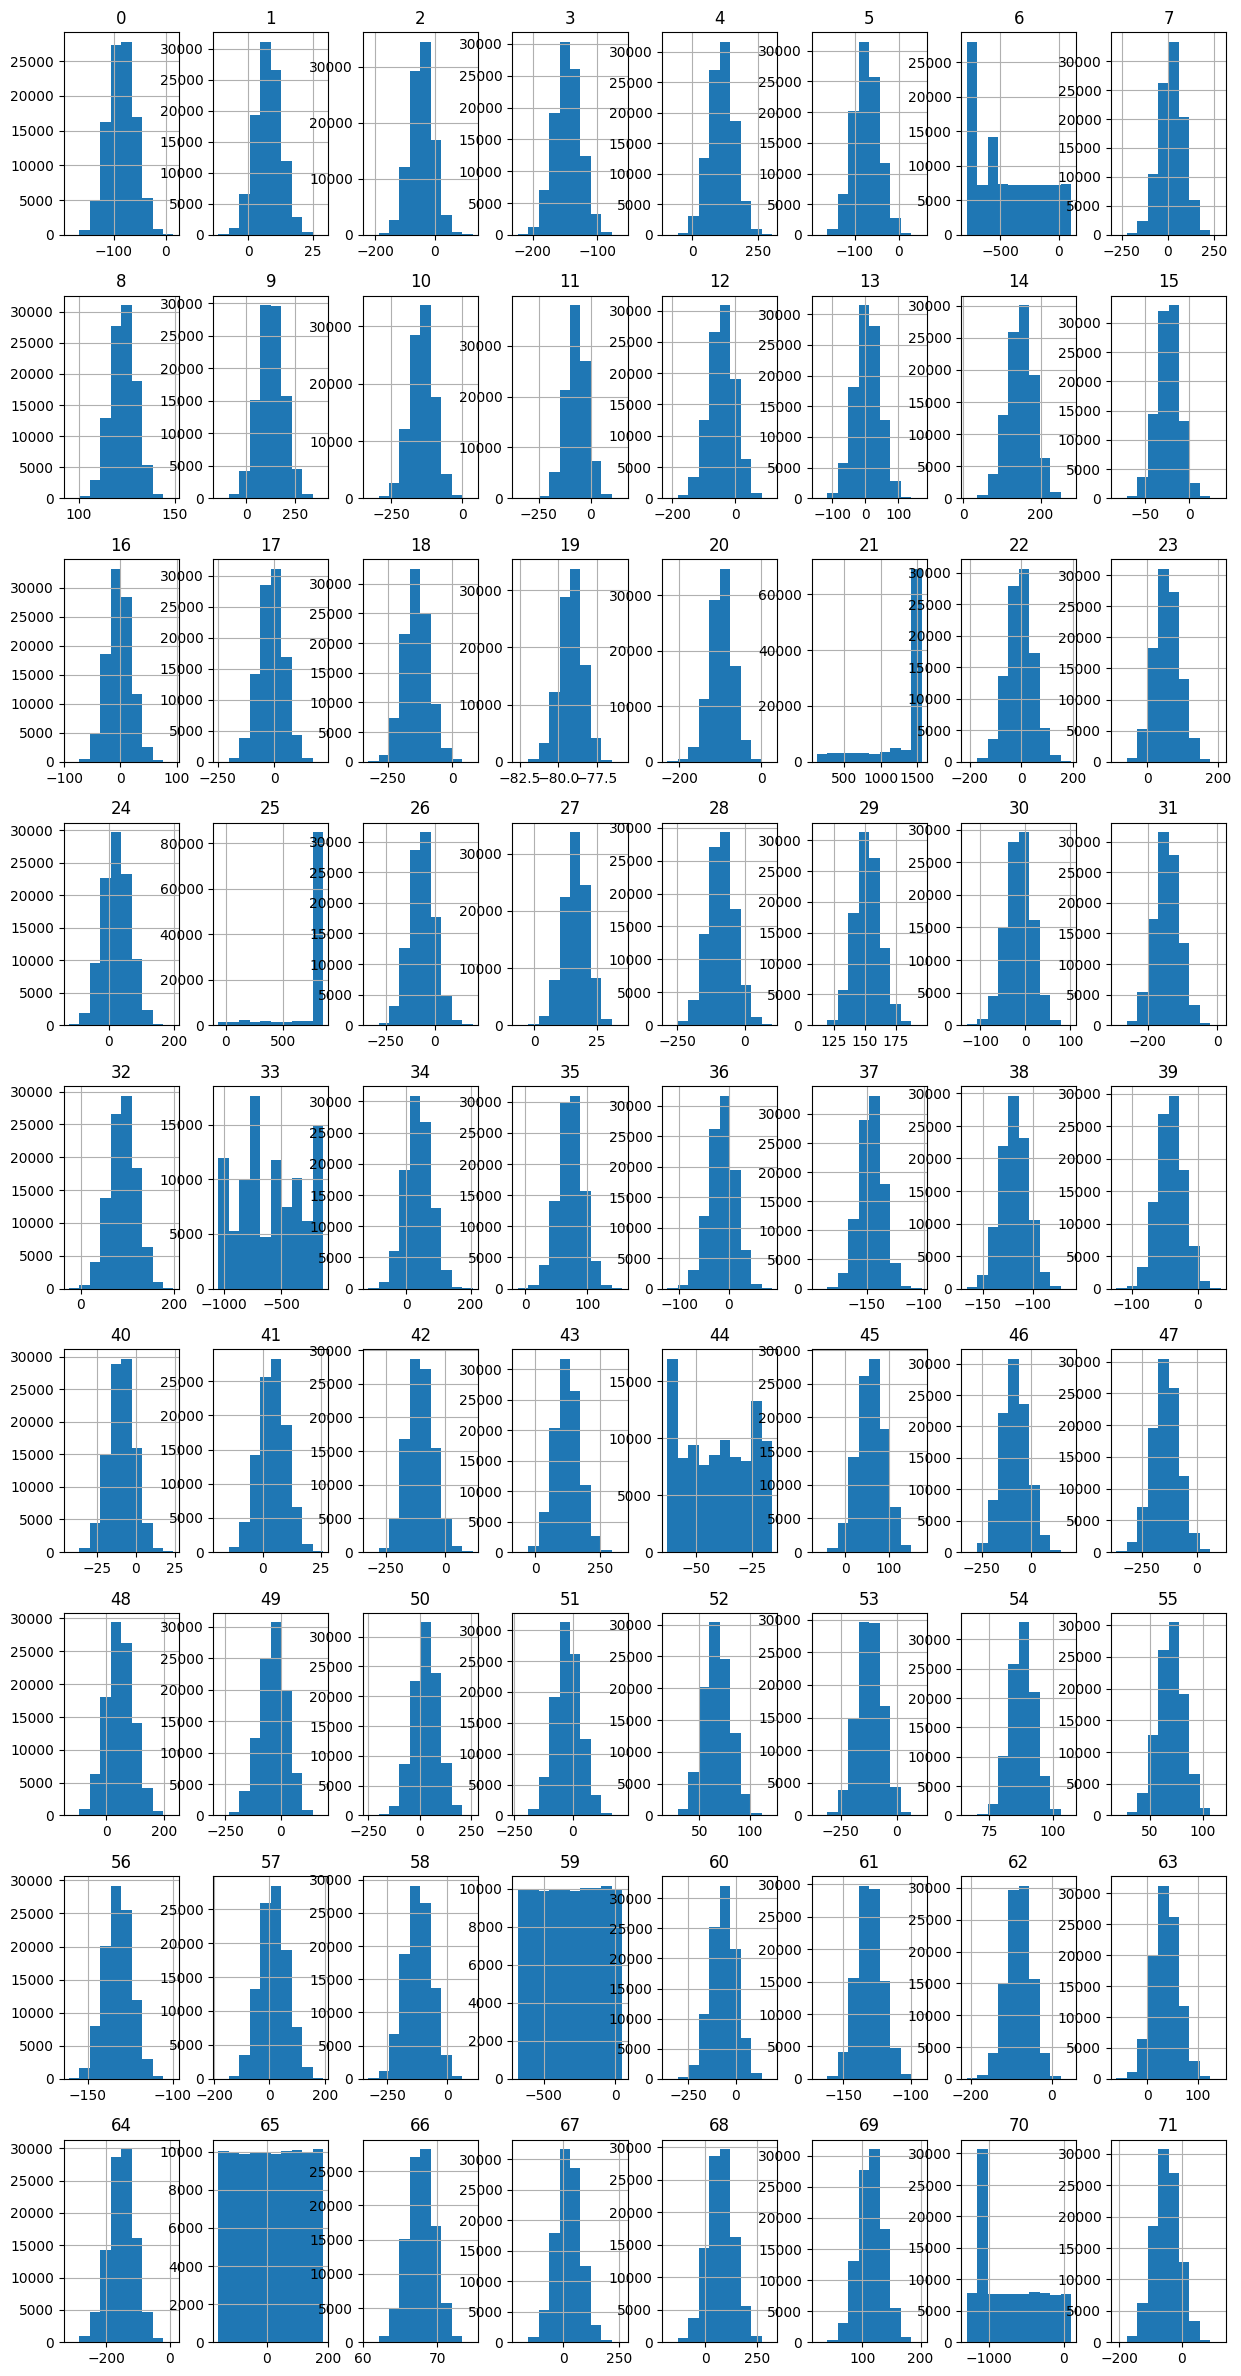

In [16]:
data_train.hist(figsize=(15, 30))
plt.show()

In [17]:
# количество уникальных значений в признаках
for col in data_train.columns:
    print(f'Количество уникальных значений {col}', {data_train[col].value_counts().count()})

Количество уникальных значений Id {100000}
Количество уникальных значений 0 {95977}
Количество уникальных значений 1 {96116}
Количество уникальных значений 2 {96174}
Количество уникальных значений 3 {95373}
Количество уникальных значений 4 {96049}
Количество уникальных значений 5 {95995}
Количество уникальных значений 6 {69462}
Количество уникальных значений 7 {96215}
Количество уникальных значений 8 {94591}
Количество уникальных значений 9 {96106}
Количество уникальных значений 10 {95911}
Количество уникальных значений 11 {96138}
Количество уникальных значений 12 {96168}
Количество уникальных значений 13 {96204}
Количество уникальных значений 14 {95791}
Количество уникальных значений 15 {96077}
Количество уникальных значений 16 {96249}
Количество уникальных значений 17 {96190}
Количество уникальных значений 18 {95967}
Количество уникальных значений 19 {84396}
Количество уникальных значений 20 {95949}
Количество уникальных значений 21 {20650}
Количество уникальных значений 22 {96199}
К

In [18]:
unique, counts = np.unique(data_train['33'], return_counts= True)

In [19]:
cat_col_33 = pd.DataFrame(data={'unique': unique, 'counts': counts})
cat_col_33.sort_values(by='counts', ascending=False)

,unique,counts
1539,-156.249890,7715
49,-1018.469545,6858
927,-529.295053,6106
491,-771.296708,4420
560,-735.671365,3763
...,...,...
1046,-462.905493,1
141,-970.832209,1
1047,-460.697946,1
715,-654.553309,1


__Вывод:__  Имеем данные состоящие из 71 признаков и 100000 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Необходима стардартизация. Много памяти занимает датафрейм.

Товары из base соответствуют нескольким значениям

Все признаки кроме 6 21 25 33 44 59 65 70 имеют нормальное распределение.

### Validation

In [20]:
info(data_valid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
84560,184560-query,-79.020110,9.663517,-52.141243,-175.42244,163.567320,-46.260770,-759.626065,124.863950,121.605650,112.480830,-96.89548,-74.273220,-69.085080,8.780375,161.31787,-11.652089,1.663231,-1.193026,-169.318330,-78.990930,-151.996950,279.966838,-67.578370,31.836690,22.394585,813.770071,-32.091446,26.661210,-44.052480,146.02545,-31.952515,-115.755900,61.118668,-172.583185,-16.293290,94.977390,-61.198900,-141.06909,-137.14166,-54.436256,-7.644395,10.416000,-64.504030,139.304780,-16.665460,11.624550,-22.113312,-98.932080,44.428170,-32.954575,79.327670,-15.475586,49.517586,-121.217880,84.020660,86.537430,-131.533900,88.445270,-91.837395,-95.335092,26.646431,-124.45777,-68.612300,-3.870075,-211.133090,-7.940897,70.698510,64.063770,111.561930,147.36244,-678.159127,-127.681885
35340,135340-query,-95.642280,13.999756,-16.978197,-157.62670,94.021996,-56.824936,-759.626065,-14.968767,115.931260,52.438150,-164.70741,15.275665,-23.613268,20.652512,159.85660,-19.338696,-17.652533,-25.439890,-199.382740,-78.669525,-120.239210,1502.158876,-12.621043,77.943634,11.467532,813.770071,-43.380090,16.053930,-117.594500,144.49994,-2.050634,-57.309303,86.302990,-178.485752,24.554745,66.618770,-58.248990,-143.22813,-122.09014,-26.805807,-2.689815,14.937846,-17.198753,117.624850,-20.868109,45.306507,-105.747635,-177.873300,28.063488,-21.007639,28.110027,-124.285300,80.640230,-60.203020,89.922400,89.687460,-130.665200,17.906376,8.817177,-45.282320,27.314910,-127.54477,-50.283640,50.371452,-86.329994,91.295665,72.064230,-15.957478,7.827519,135.18692,-159.236380,-47.447193
33011,133011-query,-86.361050,7.926848,-111.986930,-138.76254,159.064450,-99.131190,-530.124724,-57.459640,126.246630,124.665010,-101.98291,-72.784460,-75.820970,91.042690,184.34906,-41.892376,-37.726643,9.907164,-172.437710,-79.558660,-101.096600,1274.291128,1.490014,-1.249981,-13.901875,813.770071,-71.933525,16.898039,-74.577810,169.72379,12.169660,-122.654520,50.609722,-518.561149,39.888756,86.608315,-5.449895,-138.69466,-139.24452,-85.932140,-6.076089,0.677401,-121.662530,165.904300,-44.385996,58.689950,-91.074000,-121.218310,83.199936,27.249970,41.368294,59.005913,50.404343,-116.454704,91.914070,83.254330,-150.615690,-27.704685,-80.041980,-366.596849,-151.083400,-133.02966,-116.872314,73.475980,-174.228700,149.191504,67.728940,74.442890,95.019980,154.61720,-439.854540,-81.156360
51124,151124-query,-69.862976,8.434676,-6.019299,-143.31703,127.063866,-94.852440,27.751557,43.419563,132.187520,186.789170,-199.86910,3.836349,-125.552124,33.560850,159.02592,-22.516674,3.341856,16.278590,-93.593720,-79.699280,-128.231890,1507.231274,26.555302,48.090637,-2.102106,813.770071,-55.467068,13.262751,-76.779144,148.15202,-11.576529,-51.830864,126.942630,-735.671365,-1.018601,77.986470,-34.575127,-139.66298,-99.67255,-55.788597,-17.492432,5.742319,-63.337143,106.765740,-21.213616,59.180244,-65.535995,-224.546170,90.606660,-125.025246,-78.604095,-49.580340,57.116160,-253.001220,87.982666,74.564520,-137.772000,-92.176720,-26.241493,-204.673701,-56.905495,-126.22498,-67.599846,26.609085,-116.191860,12.338029,68.910270,13.188719,51.876728,91.88168,-453.139440,-112.025620
78994,178994-query,-79.569020,3.771240,0.729774,-160.71193,169.313420,-72.273380,-385.014183,71.378110,127.224120,167.286480,-205.78601,-125.125336,-31.520855,5.777189,119.67296,-36.410820,-12.717694,-17.702517,-110.921265,-79.489330,-111.277930,1507.231274,10.489288,78.853480,-8.807388,813.770071,48.140892,20.105322,-105.707020,149.66083,57.709440,-125.087616,75.564280,-771.296708,72.481360,71.136570,-22.910114,-145.74731,-136.73335,-38.536100,-20.295520,1.550341,-223.097990,100.188310,-32.854203,77.078030,-143.138440,-121.634740,56.009262,-45.181557,73.292984,-60.775284,60.908485,-118.719810,82.569100,65.610550,-132

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.302233,25.777321,-190.353330,-103.231790,-85.296745,-67.422104,14.427986
1,100000.0,7.669724,4.956990,-11.109877,4.292425,7.657888,10.993900,27.409784
2,100000.0,-43.842474,39.138775,-217.538420,-69.680916,-43.230835,-17.765821,134.859800
3,100000.0,-146.119797,20.495541,-220.050890,-160.210287,-146.080365,-132.119278,-57.381890
4,100000.0,111.635071,47.751576,-81.198990,79.101920,111.959330,143.903735,302.065370
...,...,...,...,...,...,...,...,...
67,100000.0,23.250779,55.403862,-210.672800,-13.863008,23.508739,60.154775,251.288590
68,100000.0,73.114446,62.056224,-175.921780,31.494840,72.152398,114.317053,305.937530
69,100000.0,115.196935,21.493081,25.271042,100.538862,115.280990,129.770215,201.599980
70,100000.0,-709.457021,405.665764,-1297.923999,-1074.464888,-807.029697,-358.400478,98.737079


Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64
Количество дубликатов:  0
Количество признаков:  73 Количество значений:  100000


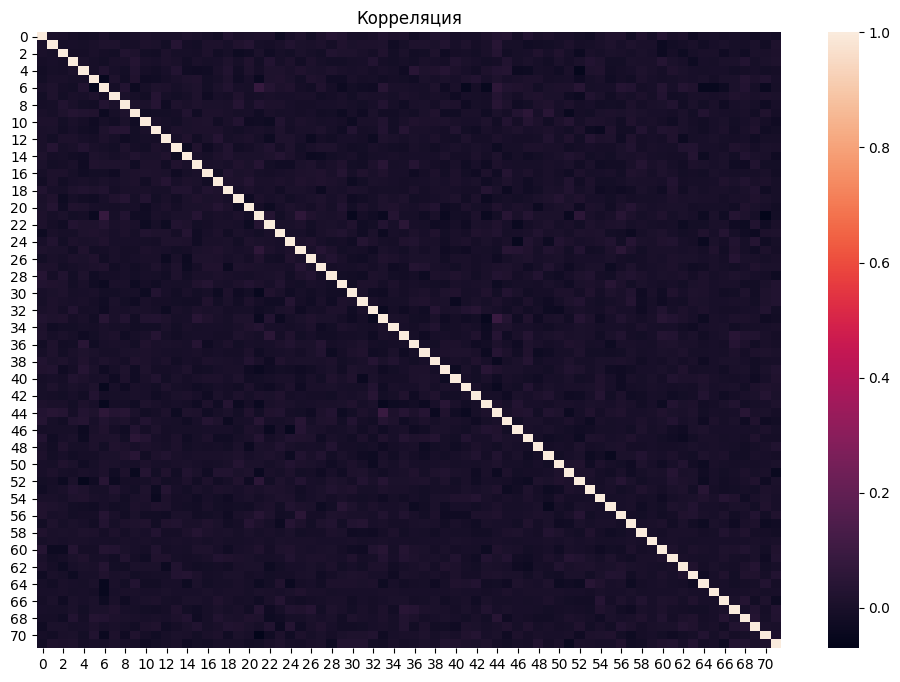

In [21]:
plt.figure(figsize=(12,8))
plt.title('Корреляция')
sns.heatmap(data_valid.corr())
plt.show()

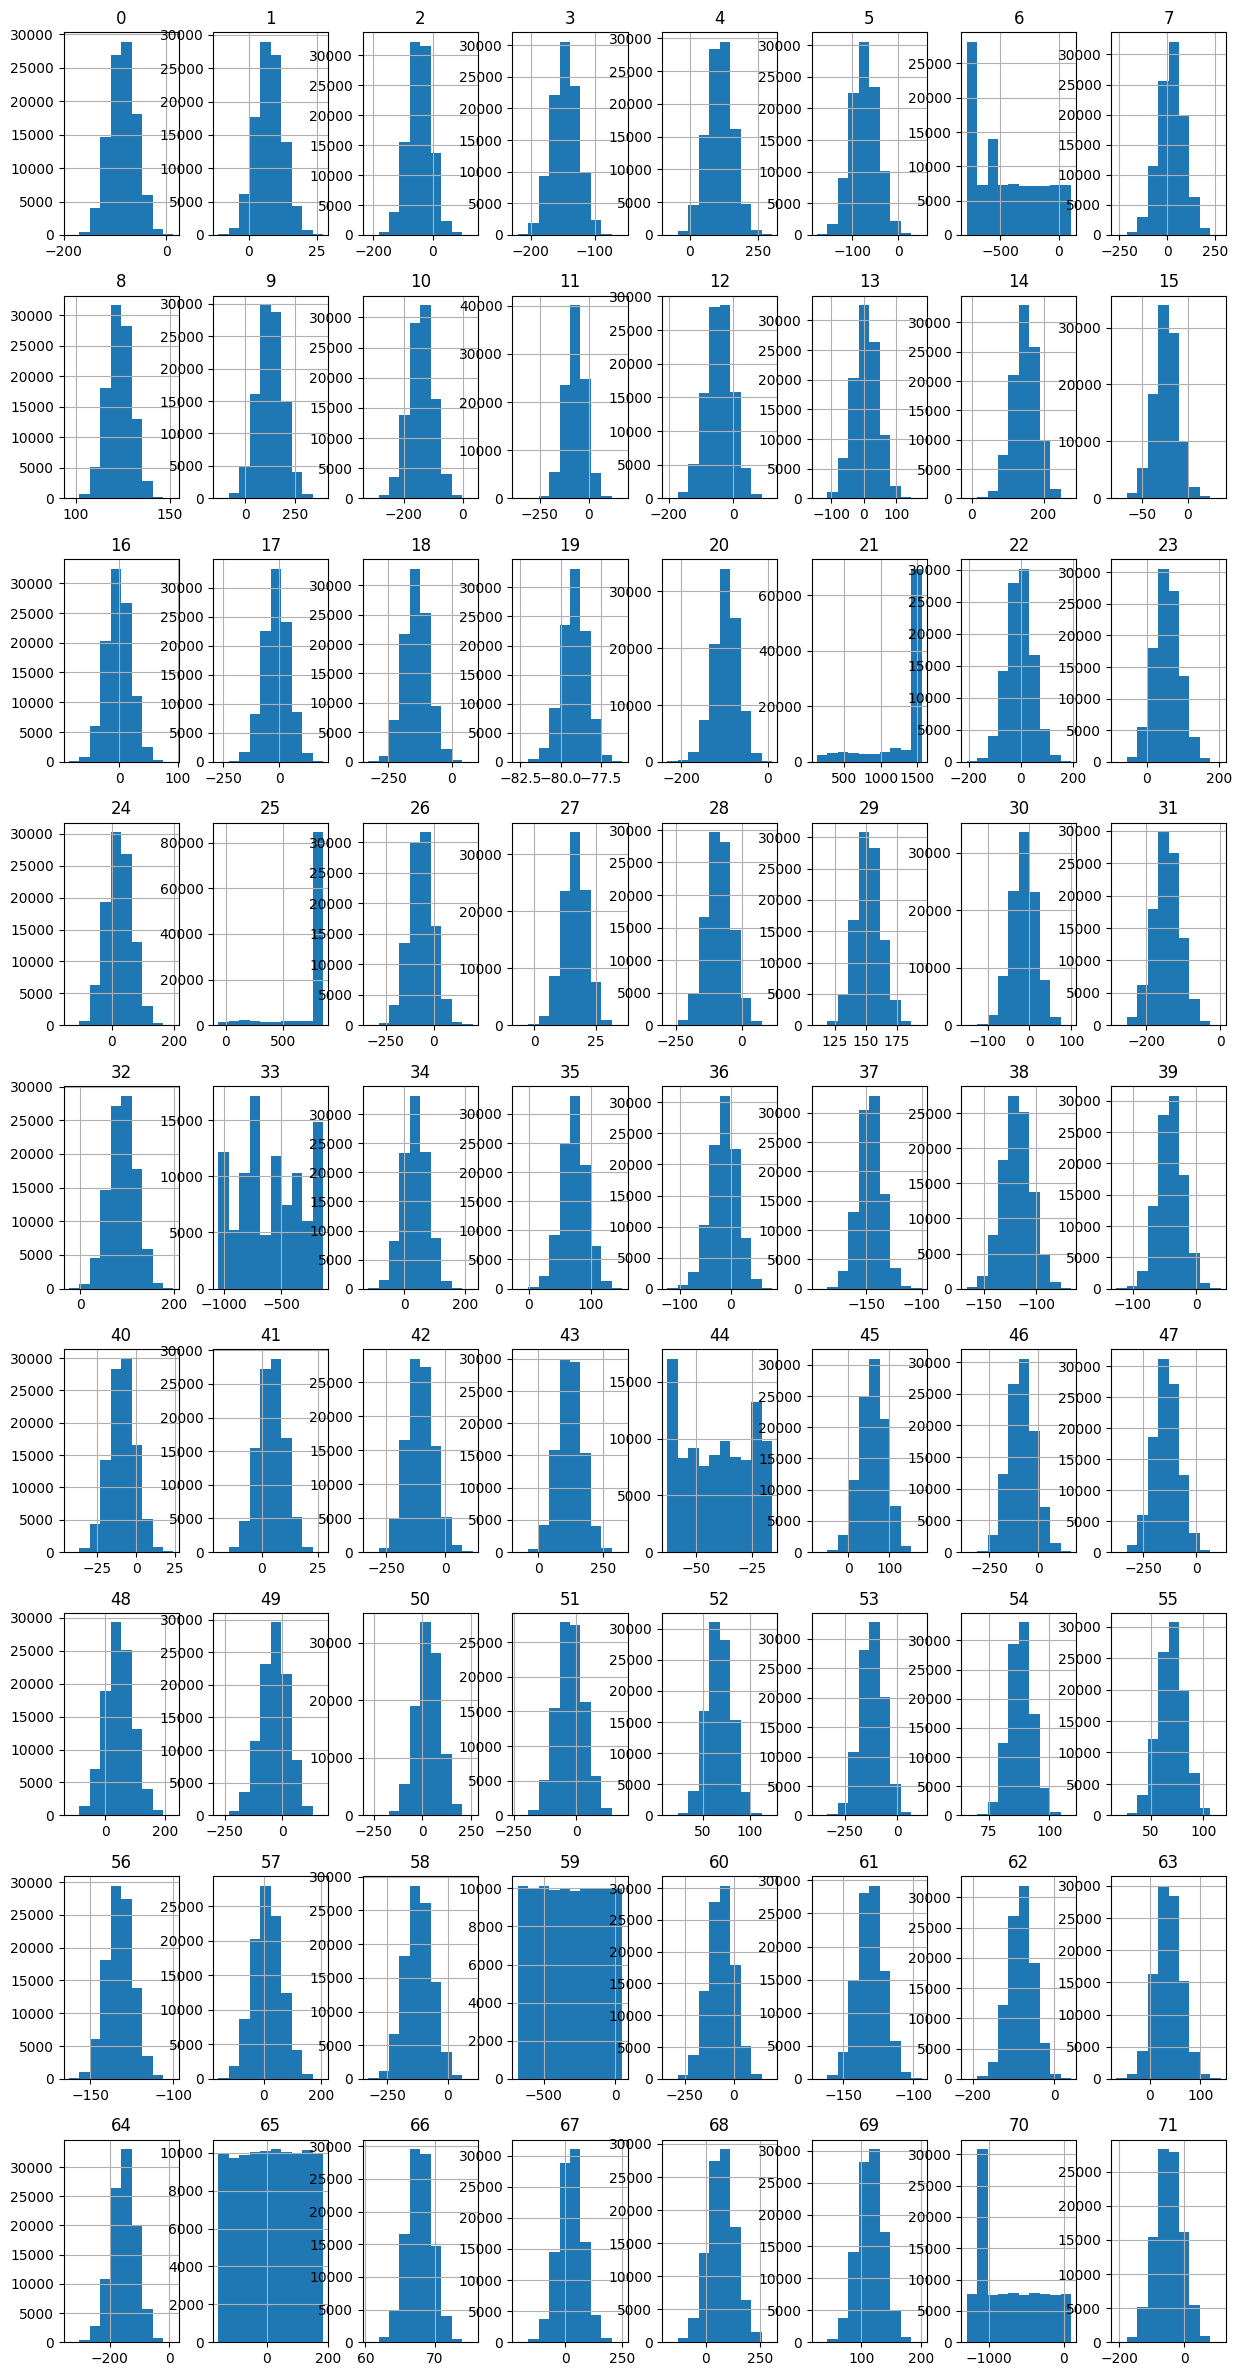

In [22]:
data_valid.hist(figsize=(15,30))
plt.show()

__Вывод:__  Имеем данные состоящие из 71 признаков и 1000000 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Необходима стардартизация. Много памяти занимает датафрейм.

Все признаки кроме 6 21 25 33 44 59 65 70 имеют нормальное распределение.

### Answer

In [23]:
info(data_valid_answer)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


None

,Id,Expected
60999,160999-query,203633-base
1229,101229-query,965583-base
24807,124807-query,2030129-base
78272,178272-query,156444-base
20036,120036-query,450075-base
52282,152282-query,439453-base
35665,135665-query,58435-base
80079,180079-query,931890-base
58268,158268-query,573626-base
69783,169783-query,1308446-base


,count,unique,top,freq
Id,100000,100000,126044-query,1
Expected,100000,91502,210304-base,7


Id          0
Expected    0
dtype: int64
Количество дубликатов:  0
Количество признаков:  2 Количество значений:  100000


__Вывод:__ Имеем даннные, состоящие из 2-х признаков и 100000 значений.
    
Товары из base соответствуют нескольким значениям

## EDA

In [24]:
# сделаем копию датасета
temp_data_base = data_base.copy()
temp_data_train = data_base.copy()
temp_data_valid = data_base.copy()
temp_data_valid_answer = data_base.copy()

### Уберем категориальные данные

In [25]:
#дропнула 21, 25, 33 44, 59 65
data_base = data_base.drop(data_base.columns[[22, 26, 34, 45, 60, 66]], axis=1)

In [26]:
data_train = data_train.drop(data_train.columns[[22, 26, 34, 45, 60, 66]], axis=1)

In [27]:
data_valid = data_valid.drop(data_valid.columns[[22, 26, 34, 45, 60, 66]], axis=1)

__Вывод:__ В ходе эксперементов по удалению признаков, признаки 6 и 70 решено было оставить. Так как при удалении, метрика падала. Сдала вывод, чем меньше у категориальных признаков уникальных значений, тем хуже они влияют на метрику.

### Поменяем тип данных

In [28]:
# функция для изменения типа данных 
def col_type_trans(data):
    cols = data.select_dtypes(include='float').columns.tolist()
    for col in cols:
        data[col] = data[col].astype(np.float32)
    return data

In [29]:
# поменяем тип данных да float32 для усменьшения памяти
col_type_trans(data_base).dtypes

Id     object
0     float32
1     float32
2     float32
3     float32
       ...   
67    float32
68    float32
69    float32
70    float32
71    float32
Length: 67, dtype: object

In [30]:
col_type_trans(data_train).dtypes

Id         object
0         float32
1         float32
2         float32
3         float32
           ...   
68        float32
69        float32
70        float32
71        float32
Target     object
Length: 68, dtype: object

In [31]:
col_type_trans(data_valid).dtypes

Id     object
0     float32
1     float32
2     float32
3     float32
       ...   
67    float32
68    float32
69    float32
70    float32
71    float32
Length: 67, dtype: object

__Вывод:__ Поменяла тип на float32, так как только с ним раьотаект библиотека Faiss. И меньше памяти занимают данные.

### Запишем названия признаков в нижнем регистре

In [32]:
# приведем все к нижнему регистру
# записать как функцию
def make_low_cols(data):
    data.columns = map(str.lower, data.columns)
    return data

In [33]:
# Запишем названия признаков в нижнем регистре
make_low_cols(data_base)
make_low_cols(data_train)
make_low_cols(data_valid)
make_low_cols(data_valid_answer)

,id,expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base
...,...,...
99995,199995-query,967418-base
99996,199996-query,1344948-base
99997,199997-query,1690782-base
99998,199998-query,341779-base


### Перезапишем id

In [34]:
# функция для замены индекса
def make_index(data):
    data = data.set_index('id')
    return data

In [35]:
data_base = make_index(data_base)
data_train = make_index(data_train)
data_valid = make_index(data_valid)
data_valid_answer = make_index(data_valid_answer)

In [ ]:
# посмотрим на результат удаления признаков
print(temp_data_base.shape, data_base.shape)
print(temp_data_train.shape, data_base.shape)
print(temp_data_valid.shape, data_base.shape)
print(temp_data_valid_answer.shape, data_base.shape)

### Масштабируем признаки

In [36]:
# Масштабимруем RobustScaler
scaler = RobustScaler()

In [37]:
# Обучаем на base и трансформируем
base_trans = scaler.fit_transform(data_base)

In [38]:
# делим трейн на фичи и тагет
train_features = data_train.drop('target', axis=1)
train_target = data_train['target'] 

In [39]:
# трансформируем трейн
train_trans = scaler.transform(train_features)

In [40]:
# трансформируем валид
valid_trans = scaler.transform(data_valid)

In [41]:
# создание словаря для нахождения индекса товара в базовом наборе данных
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

__Вывод:__ В ходе эксперемента RobustScaler показал себя лучше всего. С ним удалось добиться самой высокой метрики.

### Подберем класторы

In [42]:
# подбор кластеров
def get_clastering_coeff(df: pd.DataFrame(),\
                        n_clusters: list,
                        model = KMeans,
                        seed = RANDOM_SEED):
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]
    print ('Коэффицент схожести Девиса_Боулдина:' 'Mеньше - лучше. Минимум - 0')
    
    for ni in tqdm(n_clusters):
        if model == MiniBatchKMeans:
            cluster_k = MiniBatchKMeans(n_clusters=ni, \
                                        init = 'k-means++', 
                                        n_init = 'auto', 
                                        batch_size=1536, 
                                        random_state = seed).fit(df)
        elif model == KMeans:
            cluster_k = KMeans(n_clusters=ni, \
                               init = 'k-means++', 
                               n_init = 'auto', 
                               random_state = seed).fit(df)
        db_score = davies_bouldin_score(df, cluster_k.labels_)
        print(f'{ni} кластеров: {round(db_score, 3)}.\n-----')                   

In [43]:
get_clastering_coeff(df=data_base, n_clusters=[10, 20, 50, 100, 200, 300, 400, 500, 1000], model = MiniBatchKMeans)

Коэффицент схожести Девиса_Боулдина:Mеньше - лучше. Минимум - 0


 11%|█████                                        | 1/9 [00:08<01:11,  8.96s/it]

10 кластеров: 2.728.
-----


 22%|██████████                                   | 2/9 [00:17<00:59,  8.54s/it]

20 кластеров: 3.459.
-----


 33%|███████████████                              | 3/9 [00:27<00:55,  9.31s/it]

50 кластеров: 3.878.
-----


 44%|████████████████████                         | 4/9 [00:39<00:52, 10.44s/it]

100 кластеров: 3.954.
-----


 56%|█████████████████████████                    | 5/9 [00:57<00:52, 13.22s/it]

200 кластеров: 3.62.
-----


 67%|██████████████████████████████               | 6/9 [01:19<00:48, 16.05s/it]

300 кластеров: 3.343.
-----


 78%|███████████████████████████████████          | 7/9 [01:46<00:39, 19.79s/it]

400 кластеров: 3.179.
-----


 89%|████████████████████████████████████████     | 8/9 [02:19<00:23, 23.86s/it]

500 кластеров: 3.089.
-----


100%|█████████████████████████████████████████████| 9/9 [03:15<00:00, 21.78s/it]

1000 кластеров: 2.887.
-----


In [44]:
#get_clastering_coeff(df=data_base, n_clusters=[10, 20, 50, 100, 200, 300, 400, 500, 1000], model = KMeans) 
# очень долго считает

__Вывод:__ Лучшую метрику даст нам разбиение на 10 кластеров.

## Faiss

### Train

In [45]:
# размер пространиства
dimensions = base_trans.shape[1] 

In [46]:
quantizer = faiss.IndexHNSWFlat(dimensions, M)

In [47]:
index = faiss.IndexIVFFlat(quantizer, dimensions, N_CLUSTERS)

In [48]:
%%time
# обучение делителя пространства base_trans
index.train(np.ascontiguousarray(base_trans))

CPU times: user 1.43 s, sys: 463 ms, total: 1.89 s
Wall time: 1.83 s


In [49]:
# запишем деление 
index.add(np.ascontiguousarray(base_trans))

In [50]:
index.nprobe = NPROBE

In [57]:
%%time
train_dist, train_idx = index.search(np.ascontiguousarray(train_trans), K_NEIGHBORS)

CPU times: user 3h 49min 39s, sys: 5min 25s, total: 3h 55min 4s
Wall time: 1h 31min 35s


In [58]:
# accuracy@5
acc = 0
for target, candidates in zip(train_target.values.tolist(), train_idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accurasy@5', round(acc / len(train_idx) * 100, 2))

accurasy@5 71.95


__Вывод:__ На тренировочной выборке удалось добиться метрику accurasy@5 71.95

### Valid

In [54]:
%%time
# Применим наш подход на валидационной выборке
val_dist, val_idx = index.search(np.ascontiguousarray(valid_trans), K_NEIGHBORS)

In [55]:
data_valid_answer = data_valid_answer['expected']

In [56]:
# accuracy@5
acc = 0
for target, candidates in zip(data_valid_answer.values.tolist(), val_idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accurasy@5', round(acc / len(val_idx) * 100, 2))

accurasy@5 71.8


__Вывод:__ На валидационной выборке удалось добиться метрики accurasy@5 71.8

__Общий вывод:__

1) В ходе работы нам были предоставлены 4-и датасета.

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу

2) Данный хорошо подготовлены, отсутствуют пропуска и дубликаты. Все признаки кроме 6 21 25 33 44 59 65 70 имеют нормальное распределение. Встречаются как отрицальные, так и положительные, большой разброс зрначений.

Данные состоящие из 71 признаков и 2918139 записей в base. Train и valid bvttn 100000 значений. 

Изучили признак 33, он имеет 1568 уникальных значений. Это явно категориальный признак. Сложно предположить, что за категория, это явно не цвет и не размер. Возможно это город изготовления товара.

3) Была проведена подготовка данных, а именно: убрали категориальные данные, которые плохо влияли на мерику, изменили тип данныех, записали название признаков в нижнем регистре, перезаписали index. Для масштабирования данных был применен RobustScaler, он показал себя лучше при анализе метрики. Подобрали число кластеров для Faiss.

4) Для нахождения 5-ти вариантов наиболее похожих товаров из base для train выборки. Была применина библиотека Faiss. Для этого мы воспользовались методом IndexHNSWFlat. k_neighbors = 10, nprobe = 10. Обучили индекс на base. На тренировочной выборке удалось добиться метрику accurasy@5 = 71.95. 

5) При использовании бибилиотеки Faiss для нахождения 5-ти вариантов нахождения наиболее похожих товаров из base для valid выборки мы применили метод IndexHNSWFlat, с параметрами k_neighbors = 10, nprobe = 10. На валидационной выборке удалось добиться метрики accurasy@5 = 71.8.
 
